<a href="https://colab.research.google.com/github/galbendavids/One-Year-Survival-Analysis-of-Sepsis-Patients/blob/main/CDS_ex_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4 - Introduction to Clinical Data Science - final work


Gal Shlomo Ben David - 


In [ ]:
from __future__ import print_function
from google.colab import auth
from google.cloud import bigquery
from google.cloud.bigquery import magics
from sklearn.metrics import auc
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import re
!pip install tableone
from tableone import TableOne
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import lifelines
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



auth.authenticate_user()

In [ ]:
analysis_project = 'white-position-163511' 

admissions_table = 'physionet-data.mimiciii_clinical.admissions' 
d_icd_diagnoses_table = 'physionet-data.mimiciii_clinical.d_icd_diagnoses' 
diagnoses_icd_table = 'physionet-data.mimiciii_clinical.diagnoses_icd'
patients_table = 'physionet-data.mimiciii_clinical.patients' 
icustay_detail_table = 'physionet-data.mimiciii_derived.icustay_detail' 
martin_sepsis_table = 'physionet-data.mimiciii_derived.martin_sepsis'  
labevents_table = 'physionet-data.mimiciii_clinical.labevents'  
sofa_table = 'physionet-data.mimiciii_derived.sofa'  
sapsii_table = 'physionet-data.mimiciii_derived.sapsii' 
gcs_table = 'physionet-data.mimiciii_derived.gcs_first_day' 
icustays_table = 'physionet-data.mimiciii_clinical.icustays' 
vitals_first_day_table = 'physionet-data.mimiciii_derived.vitals_first_day'  
labs_first_day_table = 'physionet-data.mimiciii_derived.labs_first_day'
d_labitems_table = 'physionet-data.mimiciii_clinical.d_labitems' 
chartevents_table = 'physionet-data.mimiciii_clinical.chartevents'
 
 

# Preprocess queries made with the %%bigquery magic
# by substituting these values
sub_dict = {
    'analysis_project': analysis_project,
    'admissions_table': admissions_table,
    'd_icd_diagnoses_table': d_icd_diagnoses_table,
    'diagnoses_icd_table': diagnoses_icd_table,
    'patients_table': patients_table,
    'labevents_table': labevents_table,
    'd_labitems_table': d_labitems_table,
    'icustay_detail_table': icustay_detail_table,
    'martin_sepsis_table': martin_sepsis_table,
    'vitals_first_day_table': vitals_first_day_table,
    'labs_first_day_table': labs_first_day_table,
    'sofa_table': sofa_table,
    'sapsii_table': sapsii_table,
    'gcs_table': gcs_table,
    'chartevents_table': chartevents_table,
    'icustays_table': icustays_table,


    'ml_table_prefix': analysis_project + '.MIMIC.models_'
}

# Set the default project for running queries
magics.context.project = analysis_project

# Set up the substitution preprocessing injection
original_run_query = magics._run_query
def format_and_run_query(client, query, job_config=None):
  query = query.format(**sub_dict)
  #return original_run_query(client, query, job_config)
  return original_run_query(client, query, job_config)

#bigquery.magics._run_query = format_and_run_query
magics._run_query = format_and_run_query

print('analysis_project:', analysis_project)
print()
print('custom %%bigquery magic substitutions:')
for k, v in sub_dict.items():
  print(' ', '{%s}' % k, '→', v)
%config InlineBackend.figure_format = 'svg'
bq = bigquery.Client(project=analysis_project)
print (bq.list_datasets())

if 'MIMIC' not in [d.dataset_id for d in list(bq.list_datasets())]:
  dataset_id = "{}.MIMIC".format(bq.project)
  # Construct a full Dataset object to send to the API.
  # Send the dataset to the API for creation.
  # Raises google.api_core.exceptions.Conflict if the Dataset already
  # exists within the project.

  dataset = bigquery.Dataset(dataset_id)
  dataset = bq.create_dataset(dataset)  # Make an API request.

# Population definition
First, you will need to define the population. Include patients who were diag- nosed with sepsis, aged 18-89 and stayed in the ICU for at least 24 hours, and exclude patients with SOFA score ¡ 2 or w/o vital signs or w/o blood platelet levels.



In [ ]:
%%bigquery Admissioms_Patient

WITH SEPSIS_SOFA AS (
    SELECT sof.hadm_id as HADM_ID,sof.SOFA, sepsis,organ_failure,respiratory,cardiovascular,renal,hepatic,hematologic,metabolic,neurologic	
    FROM 
      `physionet-data.mimiciii_derived.martin_sepsis` as sep 
      join
      (SELECT subject_id,hadm_id,SOFA
      FROM `physionet-data.mimiciii_derived.sofa`
      WHERE SOFA>=2) as sof
      ON sep.hadm_id=sof.hadm_id
    WHERE sepsis=1)

SELECT * 
FROM 
  SEPSIS_SOFA 
  JOIN
  (SELECT Adms.SUBJECT_ID,Adms.HADM_ID,Adms.ADMITTIME,Pat.DOD_SSN,DATETIME_DIFF( DOD_SSN,ADMITTIME,DAY) as DAYS_UNTILL_DEATH, DATETIME_DIFF( DISCHTIME,ADMITTIME,HOUR) as LOS_IN_HOURS ,GENDER as SEX , DATETIME_DIFF( ADMITTIME,DOB,YEAR) as AGE,ETHNICITY AS RACE,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE
  FROM 
    (SELECT * FROM `physionet-data.mimiciii_clinical.admissions` 
    ORDER BY ADMITTIME ASC
    )
    as Adms
    JOIN `physionet-data.mimiciii_clinical.patients` as Pat
    ON Adms.SUBJECT_ID=Pat.SUBJECT_ID
    WHERE (DATETIME_DIFF( DISCHTIME,ADMITTIME,HOUR)>23.99) AND DATETIME_DIFF( ADMITTIME,DOB,YEAR) BETWEEN 17.99 AND 89.01
    ORDER BY Adms.ADMITTIME ASC) as subject_adm
ON subject_adm.HADM_ID=SEPSIS_SOFA.HADM_ID



In [ ]:
Admissioms_Patient.to_csv("Admissioms_Patient.csv")
Admissioms_Patient['ONE_YEAR_SRVIVAL']=0
Admissioms_Patient.loc[Admissioms_Patient['DAYS_UNTILL_DEATH'] > 365, "ONE_YEAR_SRVIVAL"] = 1
Admissioms_Patient.loc[Admissioms_Patient['DAYS_UNTILL_DEATH'] <= 365, "ONE_YEAR_SRVIVAL"] = 0
Admissioms_Patient['DAYS_UNTILL_DEATH'].fillna(10000, inplace=True)
Admissioms_Patient=Admissioms_Patient.drop(columns=['HADM_ID_1'])

Admissioms_Patient['hadm_id']=Admissioms_Patient['HADM_ID']
   
Admissioms_Patient



In [ ]:
%%bigquery vital_signs_2
SELECT subject_id, HR AS HEART_RATE_HR,  BPSys AS SYSTOLIC_BLOOD_PRESSURE_SBP, BPDias AS DIASTOLIC_BLOOD_PRESSURE_DBP
FROM `physionet-data.mimiciii_derived.echo_data`
ORDER BY subject_id ASC

In [ ]:
vital_signs_2.to_csv("vital_signs_2.csv")
vital_signs_2

#MISSING : RR(RESPORATORY RATE), TEMPERATURE- I CANT FIND THEM..

In [ ]:
%%bigquery ALL_LABS_NAME

SELECT DISTINCT  ITEMID, LABEL
FROM `physionet-data.mimiciii_clinical.labevents` JOIN `physionet-data.mimiciii_clinical.d_labitems` 
USING (ITEMID)
ORDER BY LABEL ASC


In [ ]:
#THIS TABLE IS CREATED IN ORDER TO UNDERTAND WHICH LAB TEST WE ARE WILLING TO READ

ALL_LABS_NAME.to_csv("ALL_LABS_NAME.csv")

ALL_LABS_NAME

In [ ]:
%%bigquery LABS_
SELECT subject_id AS SUBJECT_ID, hadm_id as HADM_ID, icustay_id,(CREATININE_min+CREATININE_max)/2 AS CREATININE,(GLUCOSE_min+GLUCOSE_max)/2 AS GLUCOSE,(HEMOGLOBIN_min+HEMOGLOBIN_max)/2 AS HEMOGLOBIN,
 (PLATELET_min+PLATELET_max)/2 AS PLATELET, (PTT_min+PTT_max)/2 AS PTT, (INR_min+INR_max)/2 AS INR,(PT_min+PT_max)/2 AS PT, (BUN_min+BUN_max)/2 AS BUN, (WBC_min+WBC_max)/2 AS WBC,POTASSIUM_min,
  POTASSIUM_max, SODIUM_min, SODIUM_max
FROM physionet-data.mimiciii_derived.labsfirstday

In [ ]:
LABS_.dropna()

,SUBJECT_ID,HADM_ID,icustay_id,CREATININE,GLUCOSE,HEMOGLOBIN,PLATELET,PTT,INR,PT,BUN,WBC,POTASSIUM_min,POTASSIUM_max,SODIUM_min,SODIUM_max
1,46,144073,268016,0.50,522.5,6.50,285.0,26.50,1.15,13.50,16.0,3.75,2.5,4.3,118.0,133.0
5,94,183686,229012,0.65,167.5,13.50,157.5,31.00,1.00,12.00,8.5,6.80,2.5,3.4,131.0,134.0
6,109,102024,240251,7.80,110.0,11.90,150.5,31.25,1.25,14.30,48.0,7.75,6.3,6.4,137.0,138.0
7,109,136572,286860,10.45,84.5,5.90,100.5,33.60,1.30,15.00,71.0,3.95,5.5,5.6,136.0,139.0
8,109,137510,246183,5.30,74.0,8.70,83.0,48.90,3.10,29.90,25.0,2.70,6.6,6.6,134.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61526,95658,191783,285452,7.65,115.5,9.00,226.0,31.55,2.80,28.40,55.0,15.70,5.2,5.3,131.0,133.0
61528,97060,122873,297252,10.05,239.0,13.75,393.0,25.70,1.10,12.30,232.0,10.40,5.2,6.1,161.0,176.0
61529,97206,110487,260314,2.60,125.0,7.50,233.0,29.30,1.10,12.85,148.5,5.00,5.2,6.3,132.0,136.0
61530,98994,132172,236560,2.45,106.5,8.55,229.0,35.80,2.40,25.25,57.0,6.40,5.2,5.8,142.0,144.0


In [ ]:
%%bigquery risk_scores

SELECT gcs.HADM_ID ,gcs.SUBJECT_ID ,MinGCS AS GCS, GCSMotor ,GCSVerbal ,GCSEyes, sapsii.sapsii, sapsii.sapsii_prob
FROM physionet-data.mimiciii_derived.gcsfirstday as gcs JOIN physionet-data.mimiciii_derived.sapsii as sapsii USING (HADM_ID)





In [ ]:
risk_scores

#sofa is being taken in advanced

,HADM_ID,SUBJECT_ID,GCS,GCSMotor,GCSVerbal,GCSEyes,sapsii,sapsii_prob
0,177527,28448,15.0,6.0,5.0,4.0,11,0.011265
1,102161,23650,15.0,1.0,0.0,1.0,59,0.660981
2,160954,27903,15.0,6.0,5.0,4.0,12,0.013110
3,159243,9960,3.0,1.0,1.0,1.0,67,0.799323
4,112130,78716,14.0,6.0,5.0,3.0,12,0.013110
...,...,...,...,...,...,...,...,...
70235,122116,92464,8.0,4.0,2.0,2.0,61,0.700098
70236,182888,23092,4.0,1.0,1.0,2.0,61,0.700098
70237,116699,25775,15.0,1.0,0.0,1.0,61,0.700098
70238,120647,12573,15.0,5.0,0.0,2.0,61,0.700098


In [ ]:
%%bigquery VITALS_FIRST_DAY

SELECT v.hadm_id AS HADM_ID,v.tempc_mean,v.tempc_max,v.tempc_min,v.resprate_mean,v.resprate_max,v.resprate_min,r.RRT
FROM physionet-data.mimiciii_derived.vitals_first_day as v join physionet-data.mimiciii_derived.rrt as r
USING (HADM_ID)


In [ ]:
VITALS_FIRST_DAY

,HADM_ID,tempc_mean,tempc_max,tempc_min,resprate_mean,resprate_max,resprate_min,RRT
0,128652,36.958333,37.055554,36.833335,12.066667,13.0,12.0,0
1,166401,36.296296,37.833332,35.333332,10.588235,12.0,10.0,0
2,123010,37.810185,39.111112,35.722224,20.400000,45.0,9.0,0
3,183686,37.208334,37.666668,36.611112,21.000000,43.0,12.0,0
4,153952,37.049091,37.700001,35.200001,15.918033,42.0,7.0,0
...,...,...,...,...,...,...,...,...
67601,105444,36.094444,36.611111,35.555556,17.875000,41.0,10.0,0
67602,105953,36.518519,37.111111,35.888889,24.055556,41.0,18.0,0
67603,132988,36.208333,37.500000,35.500000,23.269231,41.0,15.0,0
67604,101645,36.944444,37.222222,36.444444,20.260870,41.0,15.0,0


joining the tables that we have extracted using SQL

In [ ]:

BaseLineCha = pd.merge(Admissioms_Patient, LABS_, how="inner", on="HADM_ID")

BaseLineCha['subject_id']=BaseLineCha['SUBJECT_ID_y']
BaseLineCha=BaseLineCha.drop(columns=['SUBJECT_ID_y'])
BaseLineCha=BaseLineCha.drop(columns=['SUBJECT_ID_x'])


BaseLineCha2=pd.merge(vital_signs_2, BaseLineCha, how="inner", on="subject_id")
BaseLineCha3=pd.merge(BaseLineCha2, VITALS_FIRST_DAY, how="inner", on="HADM_ID")
BaseLineCha3=pd.merge(risk_scores,BaseLineCha3,how="inner", on="HADM_ID")
BaseLineCha3=BaseLineCha3.drop_duplicates(subset=['HADM_ID'])
#BaseLineCha3=BaseLineCha3.drop(['SUBJECT_ID_1'], axis=1)
BaseLineCha3

,HADM_ID,SUBJECT_ID,GCS,GCSMotor,GCSVerbal,GCSEyes,sapsii,sapsii_prob,subject_id,HEART_RATE_HR,SYSTOLIC_BLOOD_PRESSURE_SBP,DIASTOLIC_BLOOD_PRESSURE_DBP,SOFA,sepsis,organ_failure,respiratory,cardiovascular,renal,hepatic,hematologic,metabolic,neurologic,ADMITTIME,DOD_SSN,DAYS_UNTILL_DEATH,LOS_IN_HOURS,SEX,AGE,RACE,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,ONE_YEAR_SRVIVAL,hadm_id,icustay_id,CREATININE,GLUCOSE,HEMOGLOBIN,PLATELET,PTT,INR,PT,BUN,WBC,POTASSIUM_min,POTASSIUM_max,SODIUM_min,SODIUM_max,tempc_mean,tempc_max,tempc_min,resprate_mean,resprate_max,resprate_min,RRT
0,167826,11228,15.0,6.0,0.0,3.0,59,0.660981,11228,86,129,62,15,1,1,1,1,1,1,0,0,1,2193-06-19 01:13:00,2193-06-27,8.0,208,M,46,UNKNOWN/NOT SPECIFIED,1,EMERGENCY,0,167826,200102,2.60,170.5,10.30,58.5,42.80,1.80,16.40,79.5,13.50,4.1,4.7,136.0,141.0,35.633334,36.400002,35.200001,20.214286,29.0,15.0,1
1,139580,91802,14.0,6.0,4.0,4.0,59,0.660981,91802,80,120,40,3,1,1,1,0,1,0,0,0,1,2183-02-22 20:23:00,NaT,10000.0,1121,M,84,WHITE,0,EMERGENCY,0,139580,200215,1.35,112.5,11.60,429.0,35.30,1.60,18.20,43.5,21.60,4.5,5.6,134.0,138.0,36.177778,36.944444,35.722222,17.848485,23.0,13.0,0
449,101018,99836,15.0,5.0,0.0,4.0,63,0.736299,99836,96,148,96,9,1,1,1,0,1,1,0,0,0,2116-05-21 19:23:00,2116-07-23,63.0,1365,F,52,UNABLE TO OBTAIN,0,EMERGENCY,0,101018,200347,1.80,110.5,9.05,169.0,32.35,1.50,17.15,28.0,23.30,4.0,4.6,143.0,146.0,37.291667,38.055556,36.111111,26.444444,42.0,12.0,1
1907,186838,6873,5.0,1.0,1.0,3.0,93,0.973944,6873,86,130,67,21,1,1,1,1,1,1,1,0,0,2192-12-24 22:28:00,2193-02-20,58.0,1387,M,58,WHITE,1,EMERGENCY,0,186838,200438,3.35,129.0,11.90,94.0,35.55,1.95,16.90,128.5,38.55,3.9,4.3,128.0,133.0,35.900000,36.166666,35.166668,23.888889,34.0,12.0,0
1971,187447,93701,3.0,1.0,1.0,1.0,67,0.799323,93701,74,133,54,11,1,1,0,1,1,0,1,0,0,2180-01-03 18:51:00,NaT,10000.0,787,F,84,BLACK/AFRICAN AMERICAN,0,EMERGENCY,0,187447,239686,5.65,119.0,10.75,285.5,26.55,1.10,12.65,36.0,11.10,3.1,3.4,141.0,144.0,36.095238,37.111111,35.166667,15.176471,24.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162096,124482,44941,14.0,6.0,5.0,3.0,61,0.700098,44941,96,139,63,11,1,1,0,1,1,0,0,0,0,2184-06-30 19:31:00,2184-11-06,129.0,1647,F,78,WHITE,0,EMERGENCY,0,124482,285812,1.40,162.5,10.35,334.0,45.30,1.80,19.70,15.5,21.30,4.0,4.6,133.0,138.0,37.677778,38.277778,37.166667,24.327586,34.0,14.0,1
2162102,104932,79523,15.0,1.0,0.0,1.0,61,0.700098,79523,103,96,67,17,1,1,0,1,1,1,1,0,0,2156-03-20 23:36:00,NaT,10000.0,41,F,60,UNABLE TO OBTAIN,1,EMERGENCY,0,104932,286803,2.00,223.0,10.85,108.5,69.70,2.55,26.55,25.5,3.70,3.6,5.1,135.0,142.0,36.120800,37.100000,34.100000,26.529412,30.0,12.0,1
2162104,109633,7574,13.0,6.0,3.0,4.0,61,0.700098,7574,46,100,63,14,1,1,1,1,0,1,0,0,0,2187-08-15 20:02:00,NaT,10000.0,152,F,44,WHITE,1,EMERGENCY,0,109633,288743,0.45,88.5,8.85,72.5,41.25,1.85,19.90,16.0,7.80,4.4,4.7,133.0,137.0,36.750000,37.222222,36.277778,25.125000,34.0,14.0,0
2162107,196705,87692,15.0,1.0,0.0,1.0,61,0.700098,87692,56,110,68,14,1,1,0,0,1,1,1,0,0,2151-01-13 19:17:00,NaT,10000.0,1029,M,46,HISPANIC/LATINO - DOMINICAN,0,EMERGENCY,0,196705,288862,2.40,159.0,9.80,91.0,59.60,1.80,19.15,44.0,5.20,4.6,5.5,137.0,145.0,36.562791,37.100000,36.200000,15.344262,21.0,6.0,1


DATA CLEANING

In [ ]:
BaseLineCha3['group']='Normal'
BaseLineCha3.loc[BaseLineCha3['PLATELET']>300,'group']='Thrombocytosis'
BaseLineCha3.loc[BaseLineCha3['PLATELET']<100,'group']='Thrombocytopenia'
BaseLineCha3.to_csv("BaseLineCha.csv")
BaseLineCha3

BaseLineCha3['RACE']=BaseLineCha3['RACE'].replace(['AMERICAN INDIAN/ALASKA NATIVE','AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE','HISPANIC OR LATINO','HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)','HISPANIC/LATINO - COLOMBIAN','HISPANIC/LATINO - CUBAN','HISPANIC/LATINO - DOMINICAN',
                                                   'HISPANIC/LATINO - GUATEMALAN','HISPANIC/LATINO - PUERTO RICAN','HISPANIC/LATINO - SALVADORAN','MIDDLE EASTERN','MULTI RACE ETHNICITY','NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                                                   'PATIENT DECLINED TO ANSWER','PORTUGUESE','SOUTH AMERICAN','UNABLE TO OBTAIN','UNKNOWN/NOT SPECIFIED','RRT'],'OTHER') 
BaseLineCha3['RACE']=BaseLineCha3['RACE'].replace(['ASIAN - ASIAN INDIAN','ASIAN - CAMBODIAN','ASIAN - CHINESE','ASIAN - FILIPINO','ASIAN - JAPANESE','ASIAN - KOREAN','ASIAN - OTHER','ASIAN - VIETNAMESE'],'ASIAN') 
BaseLineCha3['RACE']=BaseLineCha3['RACE'].replace(['BLACK/AFRICAN','BLACK/AFRICAN AMERICAN','BLACK/CAPE VERDEAN','BLACK/HAITIAN'],'BLACK') 
BaseLineCha3['RACE']=BaseLineCha3['RACE'].replace(['WHITE - BRAZILIAN','WHITE - EASTERN EUROPEAN','WHITE - OTHER EUROPEAN','WHITE - RUSSIAN'],'WHITE') 
BaseLineCha3.columns

In [ ]:
data=BaseLineCha3

columns = ['GCS', 'GCSMotor', 'GCSVerbal', 'GCSEyes',
       'sapsii', 'sapsii_prob', 'HEART_RATE_HR',
       'SYSTOLIC_BLOOD_PRESSURE_SBP', 'DIASTOLIC_BLOOD_PRESSURE_DBP', 'SOFA',
       'sepsis', 'organ_failure', 'respiratory', 'cardiovascular', 'renal',
       'hepatic', 'hematologic', 'metabolic', 'neurologic',
        'SEX', 'AGE', 'RACE',
        'ADMISSION_TYPE',
       'icustay_id', 'CREATININE', 'GLUCOSE', 'HEMOGLOBIN', 'PLATELET', 'PTT',
       'INR', 'PT', 'BUN', 'WBC', 'POTASSIUM_min', 'POTASSIUM_max',
       'SODIUM_min', 'SODIUM_max', 'tempc_mean', 'tempc_max', 'tempc_min',
       'resprate_mean', 'resprate_max', 'resprate_min', 'RRT', 'group']
#SOFA	HADM_ID	ADMITTIME	DOD_SSN	ONE_YEAR_SRVIVAL HOSPITAL_EXPIRE_FLAG	LOS_IN_HOURS]
categorical = ['group','SEX','RACE','ADMISSION_TYPE']
groupby = 'group'

mytable = TableOne(data, columns=columns, categorical=categorical,groupby=groupby, pval=True)
(mytable)


Grouped by group                                                                                        
                                                                            Missing             Overall              Normal    Thrombocytopenia      Thrombocytosis P-Value
n                                                                                                  5152                3063                 962                1127        
GCS, mean (SD)                                                                   28          13.5 (2.8)          13.4 (2.9)          13.6 (2.6)          13.6 (2.6)   0.009
GCSMotor, mean (SD)                                                              86           5.0 (1.6)           4.9 (1.7)           5.2 (1.5)           5.1 (1.6)  <0.001
GCSVerbal, mean (SD)                                                             71           2.9 (2.2)           2.8 (2.2)           3.3 (2.1)           2.8 (2.2)  <0.001
GCSEyes, mean (SD)                                                               44           3.0 (1.1)           2.9 (1.2)           3.1 (1.1)           3.0 (1.1)  <0.001
sapsii, mean (SD)                                                                 0         43.6 (15.4)         43.2 (14.9)         46.4 (16.8)         42.1 (15.0)  <0.001
sapsii_prob, mean (SD)                                                            0           0.3 (0.3)           0.3 (0.3)           0.4 (0.3)           0.3 (0.3)  <0.001
HEART_RATE_HR, mean (SD)                                                        910         85.6 (18.9)         84.6 (18.8)         87.0 (19.5)         86.9 (18.3)   0.001
SYSTOLIC_BLOOD_PRESSURE_SBP, mean (SD)                                          442        118.3 (33.7)        118.8 (34.0)        116.5 (42.0)        118.5 (23.2)   0.224
DIASTOLIC_BLOOD_PRESSURE_DBP, mean (SD)                                         442         64.8 (34.7)         64.3 (32.6)         65.7 (37.3)         65.3 (37.7)   0.495
SOFA, mean (SD)                                                                   0           6.8 (3.5)           6.5 (3.2)           9.0 (3.9)           5.7 (3.0)  <0.001
sepsis, mean (SD)                                                                 0           1.0 (0.0)           1.0 (0.0)           1.0 (0.0)           1.0 (0.0)     nan
organ_failure, mean (SD)                                                          0           0.9 (0.3)           0.9 (0.3)           0.9 (0.3)           0.9 (0.3)  <0.001
respiratory, mean (SD)                                                            0           0.4 (0.5)           0.4 (0.5)           0.4 (0.5)           0.4 (0.5)   0.161
cardiovascular, mean (SD)                                                         0           0.4 (0.5)           0.4 (0.5)           0.5 (0.5)           0.4 (0.5)   0.190
renal, mean (SD)                                                                  0           0.7 (0.5)           0.7 (0.5)           0.7 (0.5)           0.6 (0.5)   0.005
hepatic, mean (SD)                                                                0           0.1 (0.3)           0.1 (0.3)           0.2 (0.4)           0.1 (0.2)  <0.001
hematologic, mean (SD)                                                            0           0.2 (0.4)           0.2 (0.4)           0.6 (0.5)           0.1 (0.3)  <0.001
metabolic, mean (SD)                                                              0           0.2 (0.4)           0.2 (0.4)           0.3 (0.4)           0.2 (0.4)  <0.001
neurologic, mean (SD)                                                             0           0.1 (0.3)           0.1 (0.3)           0.1 (0.3)           0.1 (0.3)   0.256
SEX, n (%)                              F                                         0         2140 (41.5)         1256 (41.0)          382 (39.7)          502 (44.5)   0.053
                                        M                                                   3012 (58.5)        

In [ ]:
#ANOTHER CLEANING IN ORDER TO CREATE THE SURVIVAL ANALYSIS

data['blood platelets count is in normal range']=1
data.loc[data['group']=='Normal','blood platelets count is in normal range']=0
data['DAYS_UNTILL_DEATH'] = data['DAYS_UNTILL_DEATH'].values.astype(int)
data['blood platelets count is in normal range'] = data['blood platelets count is in normal range'].values.astype(int)

data.to_csv("data.csv")
data.drop_duplicates()
df=data

numeric_columns=['HEART_RATE_HR','SYSTOLIC_BLOOD_PRESSURE_SBP','DIASTOLIC_BLOOD_PRESSURE_DBP']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

categorical_feature_mask=[]
for feature in df.columns:
  if df[feature].dtype==object:
    categorical_feature_mask.append(feature)

#categorical_feature_mask = df.dtypes==object

for feature in categorical_feature_mask:
  df=pd.get_dummies(df, columns=[feature])


df=df.drop(columns=['ADMITTIME','DOD_SSN','subject_id','icustay_id'])


In [ ]:
!pip install lifelines

from lifelines import CoxPHFitter
# Python code to create the above Kaplan Meier curve
from lifelines import KaplanMeierFitter


/usr/local/lib/python3.7/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:411: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:411: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,


Text(0.5, 0, 'timeline (days)')

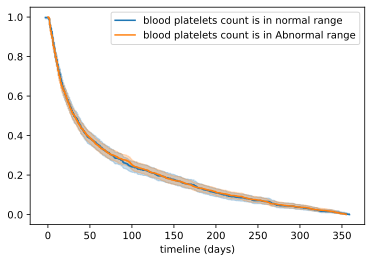

In [ ]:

cph = CoxPHFitter()
df_=df.loc[df['DAYS_UNTILL_DEATH']<360,:]
## Example Data 
durations = df_['DAYS_UNTILL_DEATH']

event_observed = pd.to_numeric(df_['ONE_YEAR_SRVIVAL'])
event_observed.dropna()

groups = df_['blood platelets count is in normal range']   
i1 = (groups == 1)      ## group i1 , having the pandas series  for the 1st cohort
i0 = (groups == 0)     ## group i2 , having the pandas series  for the 2nd cohort

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## fit the model for 1st cohort
kmf1.fit(durations[i1], event_observed[i1], label='blood platelets count is in normal range')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(durations[i0], event_observed[i0], label='blood platelets count is in Abnormal range')
kmf1.plot(ax=a1)
plt.xlabel("timeline (days)")

It is impossible to infer from this graph if a patients is having more chance to survive due to the fact that he have normal or abnormal blood platelents counts.
 

In [ ]:


indexedDataset = df.set_index(['HADM_ID'])
indexedDataset = indexedDataset.fillna(method='ffill')
#indexedDataset=indexedDataset.drop(columns=['LOS_IN_HOURS','DAYS_UNTILL_DEATH','HOSPITAL_EXPIRE_FLAG','blood platelets count is in normal range'])
indexedDataset=indexedDataset.drop(columns=['blood platelets count is in normal range'])
indexedDataset=indexedDataset.drop(columns=['SUBJECT_ID','hadm_id'])
indexedDataset=indexedDataset.drop(columns=['sepsis','SEX_F'])#as we know all paricipants in the group have sepsis, And SEX is binary in this case

indexedDataset = indexedDataset.rename(columns={'RACE_CARIBBEAN ISLAND': 'RACE_CARIBBEAN_ISLAND', 'RACE_HISPANIC/LATINO - HONDURAN': 'RACE_HISPANIC_or_LATINO_HONDURAN','RACE_HISPANIC/LATINO - MEXICAN':'RACE_HISPANIC_or_LATINO_MEXICAN'})
indexedDataset=indexedDataset.dropna()

col_labels=indexedDataset.columns
for c in col_labels:
    no_missing = indexedDataset[c].isnull().sum()
    if no_missing > 0:
        #print(c)
        #print(no_missing)
        indexedDataset[c].fillna( method ='ffill', inplace = True)
for c in col_labels:
    no_missing = indexedDataset[c].isnull().sum()
    if no_missing > 0:
        print(c)
        print(no_missing)

X=indexedDataset.drop(columns=['ONE_YEAR_SRVIVAL','DAYS_UNTILL_DEATH']).copy()
y=indexedDataset['ONE_YEAR_SRVIVAL']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)


1 YEAR SURVIVAL ANALYSIS

Univariate analysis


In [ ]:

cols_values_list = []

for single_col in X.columns:
  #for univariante
  cph_uni = lifelines.CoxPHFitter()
  cph_uni.fit(indexedDataset[[single_col, 'DAYS_UNTILL_DEATH','ONE_YEAR_SRVIVAL']], 'ONE_YEAR_SRVIVAL','DAYS_UNTILL_DEATH',step_size=0.1)

  cols_values_list.append(
              {'Feature name': single_col, 
                'Odds Ratio': cph_uni.hazard_ratios_[single_col], 
                'p-value': cph_uni.summary['p'][0], 
                'lower bound 95%': cph_uni.confidence_intervals_['95% lower-bound'][0], 
                'upper bound 95%': cph_uni.confidence_intervals_['95% upper-bound'][0]
                })

pd.DataFrame(cols_values_list)



,Feature name,Odds Ratio,p-value,lower bound 95%,upper bound 95%
0,GCS,0.995297,3.484282e-01,-0.014568,0.005140
1,GCSMotor,0.987323,1.332003e-01,-0.029412,0.003895
2,GCSVerbal,0.996296,5.614166e-01,-0.016236,0.008814
3,GCSEyes,0.986229,2.535541e-01,-0.037672,0.009937
4,sapsii,1.004771,2.232955e-07,0.002959,0.006562
5,sapsii_prob,1.350561,4.031701e-08,0.193222,0.407818
6,HEART_RATE_HR,1.002811,1.893871e-04,0.001333,0.004281
7,SYSTOLIC_BLOOD_PRESSURE_SBP,0.999182,1.043641e-01,-0.001805,0.000169
8,DIASTOLIC_BLOOD_PRESSURE_DBP,0.999857,7.564108e-01,-0.001047,0.000761
9,SOFA,1.024675,2.647746e-09,0.016349,0.032403


Multivariate analysis

In [ ]:

cph_multi = lifelines.CoxPHFitter(penalizer=0.1)
cph_multi.fit(indexedDataset, duration_col="DAYS_UNTILL_DEATH", event_col="AGE")

df_multi = pd.DataFrame()

df_multi['Odds Ratio'] = cph_multi.hazard_ratios_
df_multi['p-value'] = cph_multi.summary['p']
df_multi['lower bound 95%'] = cph_multi.confidence_intervals_['95% lower-bound']
df_multi['upper bound 95%'] = cph_multi.confidence_intervals_['95% upper-bound']

df_multi.rename(columns={0: 'Feature name'}, inplace=True)

print(df_multi.columns)


pd.DataFrame(df_multi)

Index(['Odds Ratio', 'p-value', 'lower bound 95%', 'upper bound 95%'], dtype='object')


,Odds Ratio,p-value,lower bound 95%,upper bound 95%
covariate,,,,
GCS,1.006281,2.497715e-01,-0.004401,0.016923
GCSMotor,1.015913,1.684828e-01,-0.006682,0.038257
GCSVerbal,0.988135,1.623058e-01,-0.028676,0.004805
GCSEyes,0.991578,6.295566e-01,-0.042824,0.025909
sapsii,1.004239,3.104510e-02,0.000386,0.008075
sapsii_prob,1.140691,2.610741e-01,-0.097931,0.361200
HEART_RATE_HR,1.000223,7.602597e-01,-0.001209,0.001654
SYSTOLIC_BLOOD_PRESSURE_SBP,1.000323,3.905893e-01,-0.000414,0.001060
DIASTOLIC_BLOOD_PRESSURE_DBP,0.999835,6.675995e-01,-0.000918,0.000588


In [ ]:
# i have combined those two on excel and explained the results.

Multivariate  modeling

In [ ]:
X_train.columns

Index(['GCS', 'GCSMotor', 'GCSVerbal', 'GCSEyes', 'sapsii', 'sapsii_prob',
       'HEART_RATE_HR', 'SYSTOLIC_BLOOD_PRESSURE_SBP',
       'DIASTOLIC_BLOOD_PRESSURE_DBP', 'SOFA', 'organ_failure', 'respiratory',
       'cardiovascular', 'renal', 'hepatic', 'hematologic', 'metabolic',
       'neurologic', 'LOS_IN_HOURS', 'AGE', 'HOSPITAL_EXPIRE_FLAG',
       'CREATININE', 'GLUCOSE', 'HEMOGLOBIN', 'PLATELET', 'PTT', 'INR', 'PT',
       'BUN', 'WBC', 'POTASSIUM_min', 'POTASSIUM_max', 'SODIUM_min',
       'SODIUM_max', 'tempc_mean', 'tempc_max', 'tempc_min', 'resprate_mean',
       'resprate_max', 'resprate_min', 'RRT', 'SEX_M', 'RACE_ASIAN',
       'RACE_BLACK', 'RACE_CARIBBEAN_ISLAND',
       'RACE_HISPANIC_or_LATINO_HONDURAN', 'RACE_HISPANIC_or_LATINO_MEXICAN',
       'RACE_OTHER', 'RACE_WHITE', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_URGENT', 'group_Normal',
       'group_Thrombocytopenia', 'group_Thrombocytosis'],
      dtype='object')

In [ ]:
LR = LogisticRegression(max_iter=500)

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc','balanced_accuracy']
scores = cross_validate(LR, X_train, y_train, scoring=scoring, cv=7)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()
LR_ba = scores['test_balanced_accuracy'].mean()

print(X_train.columns)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated.

Index(['GCS', 'GCSMotor', 'GCSVerbal', 'GCSEyes', 'sapsii', 'sapsii_prob',
       'HEART_RATE_HR', 'SYSTOLIC_BLOOD_PRESSURE_SBP',
       'DIASTOLIC_BLOOD_PRESSURE_DBP', 'SOFA', 'organ_failure', 'respiratory',
       'cardiovascular', 'renal', 'hepatic', 'hematologic', 'metabolic',
       'neurologic', 'LOS_IN_HOURS', 'AGE', 'HOSPITAL_EXPIRE_FLAG',
       'CREATININE', 'GLUCOSE', 'HEMOGLOBIN', 'PLATELET', 'PTT', 'INR', 'PT',
       'BUN', 'WBC', 'POTASSIUM_min', 'POTASSIUM_max', 'SODIUM_min',
       'SODIUM_max', 'tempc_mean', 'tempc_max', 'tempc_min', 'resprate_mean',
       'resprate_max', 'resprate_min', 'RRT', 'SEX_M', 'RACE_ASIAN',
       'RACE_BLACK', 'RACE_CARIBBEAN_ISLAND',
       'RACE_HISPANIC_or_LATINO_HONDURAN', 'RACE_HISPANIC_or_LATINO_MEXICAN',
       'RACE_OTHER', 'RACE_WHITE', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_URGENT', 'group_Normal',
       'group_Thrombocytopenia', 'group_Thrombocytosis'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

Multivariate Model discrimination

In [ ]:
print('LR_fit_time')
LR_fit_time = scores['fit_time'].mean()
print(LR_fit_time)

print('score_time')
LR_score_time = scores['score_time'].mean()
print(LR_score_time)

print('test_accuracy')
LR_accuracy = scores['test_accuracy'].mean()
print(LR_accuracy)

print('test_precision_macro')
LR_precision = scores['test_precision_macro'].mean()
print(LR_precision)

print('test_recall_macro')
LR_recall = scores['test_recall_macro'].mean()
print(LR_recall)


print('test_f1_weighted')
LR_f1 = scores['test_f1_weighted'].mean()
print(LR_f1)

print('test_roc_auc')
LR_roc = scores['test_roc_auc'].mean()
print(LR_roc)

print('test_balanced_accuracy')
LR_ba = scores['test_balanced_accuracy'].mean()
print(LR_ba)




LR_fit_time
0.9296665191650391
score_time
0.011437586375645228
test_accuracy
0.8659516202647193
test_precision_macro
0.4577465800458448
test_recall_macro
0.5004054843897588
test_f1_weighted
0.8062574189928225
test_roc_auc
0.6886107906447594
test_balanced_accuracy
0.5004054843897588


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.729


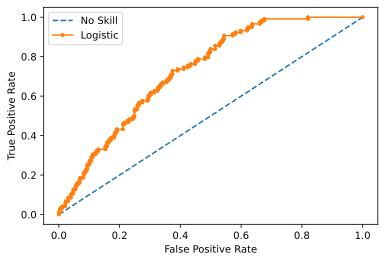

In [ ]:

LR.fit(X_train,y_train)
lr_probs = LR.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]#majority rule prediction
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Multivariate Model calibration

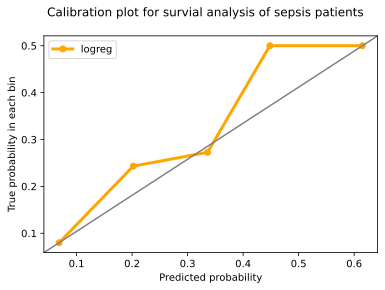

In [ ]:
%matplotlib inline
from sklearn.calibration import calibration_curve
logreg_y, logreg_x = calibration_curve(y_test, lr_probs, n_bins=7)


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg_x,logreg_y, marker='o', linewidth=3, label='logreg',color='orange')


# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='grey')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for survial analysis of sepsis patients')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()